In [12]:
import numpy as np
import time
from skimage.morphology import label
import requests
from bs4 import BeautifulSoup
import copy
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
# Started by looking at a simple soduku solver and then solved the previous 2 puzzles to get an idea of how this one works.
# Could do far more on limiting the permissable placements. 
# My solver works better on these than the Mar 2019 puzzles
# Bottom right would be faster with better use of looks to limit the placements

url='https://www.janestreet.com/puzzles/twenty-four-seven-2-by-2-2/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:12]))

Each of the grids below is incomplete. Place numbers in some of the empty cells so that in total each grid’s interior contains one 1, two 2’s, etc., up to seven 7’s. Furthermore, each row and column within each grid must contain exactly 4 numbers which sum to 20. Finally, the numbered cells must form a connected region, but every 2-by-2 subsquare in the completed grid must contain at least one empty cell. Some numbers have been placed inside each grid. Additionally, some blue numbers have been placed outside of the grids. These blue numbers indicate the first value seen in the corresponding row or column when looking into the grid from that location. Once each of the grids is complete, create a 7-by-7 grid by “adding” the four grids’ interiors together (as if they were 7-by-7 matrices). The answer to this month’s puzzle is the sum of the squares of the values in this final grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2020/12/image.png" width="500" height="600">

In [3]:
# Set up the grids to be solved

grid4 =np.array([[0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,3],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,4,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,3,0,0,0,0]])

top_looks4 = [0,0,0,0,0,0,0]
bot_looks4 = [0,6,0,5,0,4,0]
left_looks4 = [1,2,3,4,5,6,7]
right_looks4 = [0,6,0,4,0,2,0]

grid3 =np.array([[0,0,0,0,4,0,0],
                 [0,6,0,0,0,0,0],
                 [4,0,0,0,0,0,6],
                 [0,0,0,0,0,0,0],
                 [6,0,0,0,0,0,4],
                 [0,0,0,0,0,6,0],
                 [0,0,4,0,0,0,0]])

top_looks3 = [7,0,0,5,0,7,0]
bot_looks3 = [0,7,0,3,0,0,5]
left_looks3 = [0,0,0,7,0,0,0]
right_looks3 = [0,0,0,5,0,0,0]

grid2 =np.array([[0,2,0,0,0,0,0],
                 [2,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,3,0],
                 [0,0,0,0,3,0,0],
                 [0,0,0,3,0,0,0],
                 [0,0,0,0,0,0,1]])

top_looks2 = [0,0,5,6,0,6,7]
bot_looks2 = [6,7,5,0,0,0,0]
left_looks2 = [0,0,5,6,0,7,6]
right_looks2 = [6,6,4,0,0,0,0]

grid1 =np.array([[0,0,4,0,0,0,0],
                 [0,0,0,6,0,0,0],
                 [5,0,0,0,0,0,0],
                 [0,3,0,0,0,6,0],
                 [0,0,0,0,0,0,2],
                 [0,0,0,1,0,0,0],
                 [0,0,0,0,4,0,0]])

top_looks1 = [5,4,0,0,0,7,5]
bot_looks1 = [5,7,0,0,0,3,6]
left_looks1 = [5,7,0,0,0,5,7]
right_looks1 = [7,4,0,0,0,7,6]

# Use -1 for empty rather than zero to track completion of cells
grid1[grid1==0]=-1
grid2[grid2==0]=-1
grid3[grid3==0]=-1
grid4[grid4==0]=-1

In [4]:
# Set up a class to represent the matrix
# methods to 
# - print
# - check a possible placement
#   - to check 2x2 placement isn't violated
#   - to check there aren't too many small numbers in a row or column
#   - to check looks aren't violated
#  - Recursively solve the problem

class Matrix():
    def __init__(self,input_grid,top_looks,bot_looks,left_looks,right_looks):
        self.grid = input_grid
        self.top_looks = top_looks
        self.bot_looks = bot_looks
        self.left_looks =left_looks
        self.right_looks = right_looks
        self.counts = {i:i-np.sum(self.grid==i) for i in range(8)}
        print("Starting number count",self.counts)
        print('\nThe problem - Start {}'.format(time.strftime('%X')))
        self.printGrid()

# Function to print the grid
    def printGrid(self):
        print(self.grid)
        
# Function to check if a digit can be placed in the given block
# Various checks in the main block with more complex checks on small numbers, 2x2 and "looks" moved to separate functions
    def possible(self,row,col,digit):

        # Check row and columns don't have too many zeros
        if digit ==0:
            if np.sum(self.grid[:,col]==0) > 2:
                #print('fail1')
                return False
            if np.sum(self.grid[row,:]==0) > 2:
                #print('fail2')
                return False
            
        # Check that final number placed completes
        if digit !=0:
            if np.sum(self.grid[row,:]>0) > 2:
                if np.sum(self.grid[row,:])+digit+np.sum(self.grid[row,:]==-1)  != 20:
                    return False
                    
            if np.sum(self.grid[:,col]>0) > 2:
                if np.sum(self.grid[:,col])+digit+np.sum(self.grid[:,col]==-1)  != 20:
                    return False
        
        # Check row and columns don't exceed sum
        if np.sum(self.grid[:,col])+digit+np.sum(self.grid[:,col]==-1) > 20:
            return False
        
        if np.sum(self.grid[row,:])+digit+np.sum(self.grid[row,:]==-1)  > 20:
            return False
        
        #check 2x2
        if digit !=0:
            if self.twobytwo(row,col):
                return False
            
        # Check forbidden nums
            if self.more_constraints(self.grid[row,:],digit):
                return False
        
            if self.more_constraints(self.grid[:,col],digit):
                return False
            
            if self.check_looks(row,col,digit):
                return False
        
        #checkconnected (nice trick with sk-image -thanks stackexchange!)
        if np.max(label(self.grid!=0,connectivity=1)) >1 :
            return False
        
        # All tests pass return True
        return True
    
# check if placing a number violates the 2x2 rule
    def twobytwo(self,i,j):
        if (i > 0 and j > 0 and 
        self.grid[i-1,j-1] > 0 and 
        self.grid[i-1,j] > 0 and 
        self.grid[i,j-1] > 0):
            return True
    
        if (i > 0 and j < 6 and
        self.grid[i-1,j+1] > 0 and 
        self.grid[i-1,j] > 0 and 
        self.grid[i,j+1] > 0):
            return True
    
        if (i < 6 and j > 0 and
        self.grid[i+1,j-1] > 0 and 
        self.grid[i+1,j] > 0 and 
        self.grid[i,j-1] > 0):
            return True

    
        if (i < 6 and j < 6 and
        self.grid[i+1,j+1] > 0 and 
        self.grid[i+1,j] > 0 and 
        self.grid[i,j+1] > 0):
            return True
    
        return False
    
# check to see if there are too many small numbers in a row or column
    def more_constraints(self,array,digit):
        if np.sum(array==1) > 0:
            if digit < 5:
                return True
            return False
        
        if np.sum(array==2) > 0:
            if digit < 4 :
                return True
            return False
    
        if np.sum(array==3) > 0:
            if digit < 3 :
                return True
            return False
    
        if np.sum(array==4) > 0:
            if digit < 2 :
                return True
            return False
        
        return False
        
# check to see if the looks are correct 
    def check_looks(self,row,col,digit):
        if self.left_looks[row] > 0:
            found = False
            for i in range(5):
                if found == False:
                    if self.grid[row,i] != 0:
                        found = True
                        if i == col:
                            if self.left_looks[row] != digit:
                                return True
    
        if self.top_looks[col] > 0:
            found = False
            for i in range(5):
                if found == False:
                    if self.grid[i,col] != 0:
                        found = True
                        if i == row:
                            if self.top_looks[col] != digit:
                                return True

        if self.right_looks[row] > 0:
            found = False
            for i in range(6,4,-1):
                if found == False:
                    if self.grid[row,i] != 0:
                        found = True
                        if i == col:
                            if self.right_looks[row] != digit:
                                return True
    
        if self.bot_looks[col] > 0:
            found = False
            for i in range(6,4,-1):
                if found == False:
                    if self.grid[i,col] != 0:
                        found = True
                        if i == row:
                            if self.bot_looks[col] != digit:
                                return True
        return False    
        
# ======================================================================================================
# The main function. Loop throught the cells trying to place a digit, if the digit is allowed carry on 
# and recall the function recursively until that is not allowed. Then backtrack and retry. Based on the 
# simple soduku solver here :
# https://medium.com/daily-python/solving-sudoku-puzzle-using-backtracking-in-python-daily-python-29-99a825042e
# which is where I started on this.

    def solve(self):
   
        for row in range(7):
            for col in range(7):
                if self.grid[row,col] == -1:
                    for digit in range(7,-1,-1):
                        if (digit ==0 or self.counts[digit]>0):
                            if self.possible(row,col,digit):
                                self.grid[row,col] = digit
                                self.counts[digit] -= 1
                                self.solve()
                                self.grid[row,col] = -1  #Backtrack step
                                self.counts[digit] += 1
                    return 
        
        print('\nThe solution - End {}'.format(time.strftime('%X')))
        self.solution = copy.copy(self.grid)

In [5]:
# Create a separate instance of the Matrix class for each puzzle and solve.
# x1 -> x4

x1 = Matrix(grid1,top_looks1,bot_looks1,left_looks1,right_looks1)

output1 = x1.solve()
print(x1.solution)
print('\n Finish {}'.format(time.strftime('%X')))

Starting number count {0: 0, 1: 0, 2: 1, 3: 2, 4: 2, 5: 4, 6: 4, 7: 7}

The problem - Start 11:05:19
[[-1 -1  4 -1 -1 -1 -1]
 [-1 -1 -1  6 -1 -1 -1]
 [ 5 -1 -1 -1 -1 -1 -1]
 [-1  3 -1 -1 -1  6 -1]
 [-1 -1 -1 -1 -1 -1  2]
 [-1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1 -1  4 -1 -1]]

The solution - End 11:05:22
[[5 4 4 0 0 7 0]
 [0 0 7 6 3 4 0]
 [5 6 2 0 7 0 0]
 [0 3 0 0 6 6 5]
 [5 7 0 6 0 0 2]
 [5 0 7 1 0 0 7]
 [0 0 0 7 4 3 6]]

 Finish 11:05:23


In [6]:
x2 = Matrix(grid2,top_looks2,bot_looks2,left_looks2,right_looks2)
x2.solve()
print(x2.solution)
print('\n Finish {}'.format(time.strftime('%X')))

Starting number count {0: 0, 1: 0, 2: 0, 3: 0, 4: 4, 5: 5, 6: 6, 7: 7}

The problem - Start 11:05:23
[[-1  2 -1 -1 -1 -1 -1]
 [ 2 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  3 -1]
 [-1 -1 -1 -1  3 -1 -1]
 [-1 -1 -1  3 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1]]

The solution - End 11:05:34
[[7 2 5 6 0 0 0]
 [2 0 0 5 7 6 0]
 [5 7 4 0 0 4 0]
 [0 0 6 0 4 3 7]
 [6 4 0 0 3 0 7]
 [0 7 5 3 0 0 5]
 [0 0 0 6 6 7 1]]

 Finish 11:06:24


In [7]:
x3 = Matrix(grid3,top_looks3,bot_looks3,left_looks3,right_looks3)
x3.solve()
print(x3.solution)
print('\n Finish {}'.format(time.strftime('%X')))

Starting number count {0: 0, 1: 1, 2: 2, 3: 3, 4: 0, 5: 5, 6: 2, 7: 7}

The problem - Start 11:06:24
[[-1 -1 -1 -1  4 -1 -1]
 [-1  6 -1 -1 -1 -1 -1]
 [ 4 -1 -1 -1 -1 -1  6]
 [-1 -1 -1 -1 -1 -1 -1]
 [ 6 -1 -1 -1 -1 -1  4]
 [-1 -1 -1 -1 -1  6 -1]
 [-1 -1  4 -1 -1 -1 -1]]

The solution - End 11:06:25
[[7 2 0 0 4 7 0]
 [0 6 7 5 2 0 0]
 [4 5 0 5 0 0 6]
 [0 0 0 7 7 1 5]
 [6 7 3 0 0 0 4]
 [3 0 6 0 0 6 5]
 [0 0 4 3 7 6 0]]

 Finish 11:07:32


In [8]:
x4 = Matrix(grid4,top_looks4,bot_looks4,left_looks4,right_looks4)
x4.solve()
print(x4.solution)
print('\n Finish {}'.format(time.strftime('%X')))

Starting number count {0: 0, 1: 1, 2: 2, 3: 1, 4: 3, 5: 5, 6: 6, 7: 7}

The problem - Start 11:07:32
[[-1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  3]
 [-1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  4 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1]
 [-1 -1  3 -1 -1 -1 -1]]

The solution - End 11:12:13

The solution - End 11:14:59
[[0 0 0 1 5 7 7]
 [0 2 5 7 0 0 6]
 [3 7 0 7 0 0 3]
 [4 0 0 0 5 7 4]
 [0 5 6 5 4 0 0]
 [6 0 6 0 6 2 0]
 [7 6 3 0 0 4 0]]

 Finish 11:15:05


In [9]:
solved = np.sum((x1.solution+x2.solution+x3.solution+x4.solution)**2)
print("The solution is: ",solved)

The solution is:  8520


In [10]:
# Pull in the puzzle solution and grids from the solution page

url='https://www.janestreet.com/puzzles/solutions/december-2020-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

The four completed grids are shown to the left, and below them is the sum of the corresponding entries, whose sums of squares came to 8520


(0.0, 7.0, 7.0, 0.0)

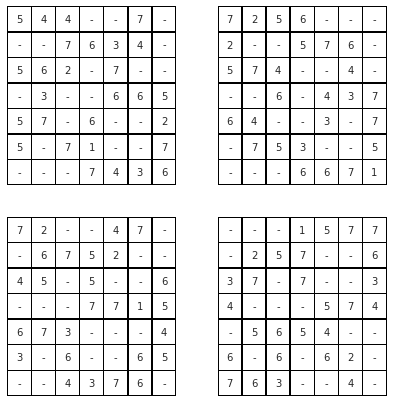

In [17]:
# Print the grids in a nice format
y = np.zeros((7,7))
fig,ax = plt.subplots(2,2,figsize =(6,6))
fig.tight_layout()


x_1 = np.array((x1.solution)).astype('int').astype('str')
x_1[x_1=="0"] ="-"
sns.heatmap(y,annot=x_1,cbar=False,cmap="gray_r",fmt="",linewidths=0.5,linecolor="k",ax=ax[0,0])
ax[0,0].axis("off")

x_2 = np.array((x2.solution)).astype('int').astype('str')
x_2[x_2=="0"] ="-"
sns.heatmap(y,annot=x_2,cbar=False,cmap="gray_r",fmt="",linewidths=0.5,linecolor="k",ax=ax[0,1])
ax[0,1].axis("off")

x_3 = np.array((x3.solution)).astype('int').astype('str')
x_3[x_3=="0"] ="-"
sns.heatmap(y,annot=x_3,cbar=False,cmap="gray_r",fmt="",linewidths=0.5,linecolor="k",ax=ax[1,0])
ax[1,0].axis("off")

x_4 = np.array((x4.solution)).astype('int').astype('str')
x_4[x_4=="0"] ="-"
sns.heatmap(y,annot=x_4,cbar=False,cmap="gray_r",fmt="",linewidths=0.5,linecolor="k",ax=ax[1,1])
ax[1,1].axis("off")

### Solution is : 

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2021/01/2020_12_Solution.png" width="500" height="600">